In [31]:
import pandas as pd

In [32]:
df = pd.read_excel('model_3.xlsx') # Считываем данные
df.head()

,id_pacienta,Vozrast,pol,staj,HbA1c,TTG,T4cv,rost,ves,Hb,...,bilirub_nepryam,VD,Angiodist,Angiopat,katapakta,miopiya,Vis(Lev),Vis(Prav),PNP_enmg,glukoza
0,301,7,0,0,15.8,3.55,12.9,128,24.0,116.0,...,0.0,-1,-1,1,-1,-1,0.4,1.0,1,1
1,301,7,0,5,12.4,5.04,15.4,127,26.0,137.0,...,0.0,-1,-1,-1,-1,-1,1.0,1.0,-1,1
2,301,8,0,16,10.3,2.11,13.5,133,30.0,127.0,...,0.0,-1,-1,-1,-1,-1,1.0,1.0,-1,1
3,301,8,0,11,0.0,0.00,0.0,130,28.0,138.0,...,0.0,-1,-1,1,-1,-1,1.0,1.0,-1,1
4,301,9,0,23,9.7,2.04,18.1,135,32.0,132.0,...,0.0,-1,1,-1,-1,-1,1.0,1.0,-1,-1


In [33]:
del df['id_pacienta']

In [34]:
X_angiopat = df.drop('Angiopat', axis = 1) # зависимые переменные
y_angiopat = df['Angiopat'] # независимая переменная
X_angiodist = df.drop('Angiodist', axis = 1) # зависимые переменные
y_angiodist = df['Angiodist'] # независимая переменная
X_vd = df.drop('VD', axis = 1) # зависимые переменные
y_vd = df['VD'] # независимая переменная

In [35]:
from sklearn.feature_selection import mutual_info_classif
mutual_info_classif(X_angiodist,y_angiodist) # вычисляем MI

array([0.00622211, 0.02009074, 0.00235975, 0.00819652, 0.00441209,
       0.01844438, 0.00088109, 0.01256593, 0.01491736, 0.        ,
       0.0089143 , 0.        , 0.01411153, 0.        , 0.00360266,
       0.        , 0.01990527, 0.00444554, 0.01251697, 0.01206701,
       0.01309586, 0.00855015, 0.0120928 , 0.01239989, 0.        ,
       0.00016319, 0.        , 0.01192062, 0.        , 0.01405167,
       0.00450981, 0.01557099, 0.00462945, 0.04073567, 0.11947951,
       0.        , 0.01675687, 0.0079936 , 0.00896981, 0.0031355 ,
       0.00156818])

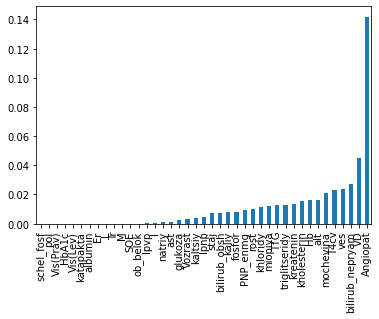

In [36]:
importances = pd.Series(mutual_info_classif(X_angiodist, y_angiodist), index=X_angiodist.columns) # записываем в Серию
importances.sort_values().plot.bar() # сортируем и рисуем столбиковую диаграмму

In [37]:
X_angiodist = X_angiodist[['T4cv', 'mochevina', 'VD', 'Angiopat']]

In [38]:
# Проведем стандартизацию данных
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_angiodist = scaler.fit_transform(X_angiodist)

In [39]:
# Вопользуемся методом главных компонент и сократим данные до 2х компонент
from sklearn.decomposition import PCA
pca_angiodist = PCA(n_components = 2) # Cоздаем экземпляр класса, n_components - количества компонент
X_pca_angiodist = pca_angiodist.fit_transform(X_angiodist) # Трансформируем данные: из 46 признаков получаем 2
X_pca_angiodist # Значения компонент

array([[-0.92945577,  1.12652941],
       [ 0.37492542,  0.26873434],
       [ 0.04215292, -0.06103218],
       ...,
       [-1.99162891,  0.23827961],
       [ 0.00737668, -0.14570486],
       [ 1.60848023, -0.51144932]])

In [40]:
# Запишем результат в новый DF и добавим столбец class
result_angiodist = pd.DataFrame()
result_angiodist['PC1'] = X_pca_angiodist[: , 0]
result_angiodist['PC2'] = X_pca_angiodist[: , 1]
result_angiodist['class'] = y_angiodist

result_angiodist.head()

,PC1,PC2,class
0,-0.929456,1.126529,-1
1,0.374925,0.268734,-1
2,0.042153,-0.061032,-1
3,-1.510347,0.781276,-1
4,0.408523,0.241730,1


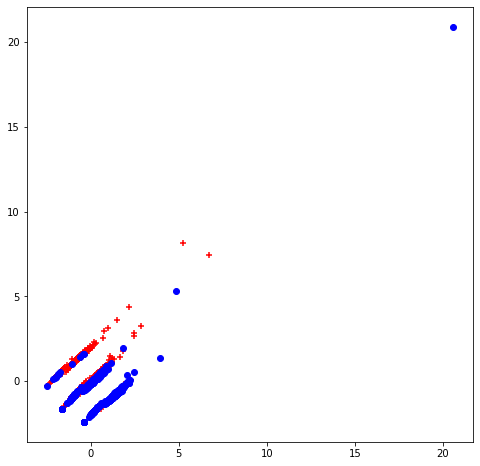

In [41]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (8,8))
r1 = result_angiodist[result_angiodist['class'] == -1]
plt.scatter(r1['PC1'], r1['PC2'], c='r', marker='+')
r2 =  result_angiodist[result_angiodist['class'] == 1]
plt.scatter(r2['PC1'], r2['PC2'], c='b', marker='o')
plt.show()

In [42]:
# Уберем выбросы с помощью DBSCAN
from sklearn.cluster import DBSCAN
import numpy as np
X = result_angiodist[['PC1', 'PC2']]
dbscan = DBSCAN(eps=1.5, min_samples=10) # Создаем экземпляр класса
labels = dbscan.fit_predict(X)
print('Получены кластеры:', np.unique(labels))
X['dbscan_lab'] = labels
X['class'] = y_angiodist

Получены кластеры: [-1  0]


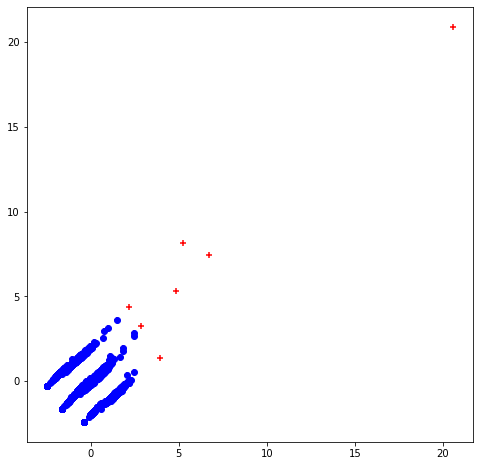

In [43]:
# Визуализируем
fig = plt.figure(figsize = (8,8))
r1 = X[X['dbscan_lab'] == -1]
plt.scatter(X['PC1'], X['PC2'], c='r', marker='+') # шум
r2 = X[X['dbscan_lab'] == 0]
plt.scatter(r2['PC1'], r2['PC2'], c='b', marker='o') # не шум
plt.show()

In [44]:
X = X[X['dbscan_lab'] == 0] # Возьмем только хорошие точки

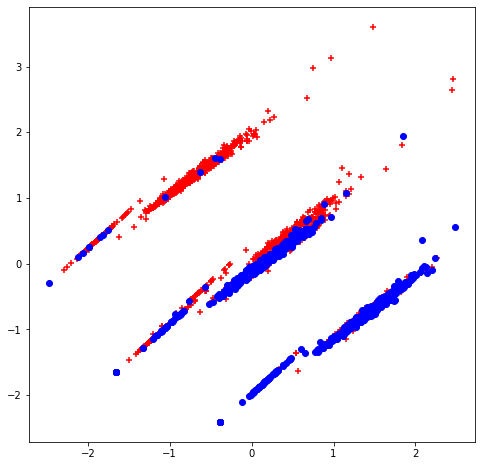

In [45]:
fig = plt.figure(figsize = (8,8))
r1 = X[X['class'] == -1]
plt.scatter(r1['PC1'], r1['PC2'], c='r', marker='+')
r2 = X[X['class'] == 1]
plt.scatter(r2['PC1'], r2['PC2'], c='b', marker='o')
plt.show()

In [46]:
X_train = X[['PC1', 'PC2']].values
y_train = X['class'].values 

In [47]:
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import accuracy_score
def classification_report_with_accuracy_score(X_angiodist, y_angiodist):
    print (classification_report(X_angiodist, y_angiodist)) # print classification report
    return accuracy_score(X_angiodist, y_angiodist) # return accuracy score

In [48]:
#Модель логистической регрессии
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C = 0.1, max_iter=500, penalty='l1', solver= 'liblinear')
logreg = logreg.fit(X_train, y_train)

In [49]:
from sklearn.model_selection import cross_val_score
# Оценим качество с помощью перекрестной проверки и доли правильных ответов
cross = cross_val_score(logreg, X_angiodist, y_angiodist, cv=5, scoring = make_scorer(classification_report_with_accuracy_score))
np.mean(cross)

              precision    recall  f1-score   support

          -1       0.81      0.86      0.83       429
           1       0.57      0.49      0.53       170

    accuracy                           0.75       599
   macro avg       0.69      0.67      0.68       599
weighted avg       0.74      0.75      0.74       599

              precision    recall  f1-score   support

          -1       0.81      0.90      0.85       429
           1       0.65      0.48      0.55       170

    accuracy                           0.78       599
   macro avg       0.73      0.69      0.70       599
weighted avg       0.77      0.78      0.77       599

              precision    recall  f1-score   support

          -1       0.80      0.86      0.83       429
           1       0.56      0.45      0.50       170

    accuracy                           0.74       599
   macro avg       0.68      0.66      0.66       599
weighted avg       0.73      0.74      0.73       599

              preci

0.7646076794657763

In [50]:
# Оценим качество с помощью перекрестной проверки и доли правильных ответов
cross = cross_val_score(logreg, X_angiodist, y_angiodist, cv=5, scoring = 'f1_weighted')
np.mean(cross)

0.755391705962737

In [51]:
#Модель случайного леса 
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators=100,
                               criterion='entropy', 
                               min_samples_split=12)
forest = forest.fit(X_train, y_train)

In [52]:
# Оценим качество с помощью перекрестной проверки и доли правильных ответов
cross = cross_val_score(forest,X_angiodist, y_angiodist, cv=5, scoring = make_scorer(classification_report_with_accuracy_score))
np.mean(cross)

              precision    recall  f1-score   support

          -1       0.81      0.83      0.82       429
           1       0.53      0.51      0.52       170

    accuracy                           0.73       599
   macro avg       0.67      0.67      0.67       599
weighted avg       0.73      0.73      0.73       599

              precision    recall  f1-score   support

          -1       0.82      0.87      0.84       429
           1       0.61      0.51      0.56       170

    accuracy                           0.77       599
   macro avg       0.71      0.69      0.70       599
weighted avg       0.76      0.77      0.76       599

              precision    recall  f1-score   support

          -1       0.81      0.83      0.82       429
           1       0.54      0.49      0.52       170

    accuracy                           0.74       599
   macro avg       0.67      0.66      0.67       599
weighted avg       0.73      0.74      0.73       599

              preci

0.7452420701168615

In [53]:
from sklearn.model_selection import cross_val_score
# Оценим качество с помощью перекрестной проверки и доли правильных ответов
cross = cross_val_score(forest, X_train, y_train, cv=5, scoring = 'f1_weighted')
np.mean(cross)

0.7136911022416711

In [54]:
#Градиентный бустинг
from sklearn.ensemble import GradientBoostingClassifier
gradient = GradientBoostingClassifier(n_estimators=100,                                
                                    max_depth=7)
gradient = gradient.fit(X_train, y_train)

In [55]:
# Оценим качество с помощью перекрестной проверки и доли правильных ответов
cross = cross_val_score(gradient,X_angiodist, y_angiodist, cv=5, scoring = make_scorer(classification_report_with_accuracy_score))
np.mean(cross)

              precision    recall  f1-score   support

          -1       0.81      0.81      0.81       429
           1       0.52      0.51      0.52       170

    accuracy                           0.73       599
   macro avg       0.66      0.66      0.66       599
weighted avg       0.73      0.73      0.73       599

              precision    recall  f1-score   support

          -1       0.80      0.84      0.82       429
           1       0.54      0.46      0.50       170

    accuracy                           0.73       599
   macro avg       0.67      0.65      0.66       599
weighted avg       0.72      0.73      0.73       599

              precision    recall  f1-score   support

          -1       0.82      0.83      0.83       429
           1       0.56      0.54      0.55       170

    accuracy                           0.75       599
   macro avg       0.69      0.68      0.69       599
weighted avg       0.75      0.75      0.75       599

              preci

0.7375626043405676

In [56]:
from sklearn.model_selection import cross_val_score
# Оценим качество с помощью перекрестной проверки и доли правильных ответов
cross = cross_val_score(gradient, X_train, y_train, cv=5, scoring = 'f1_weighted')
np.mean(cross)

0.7108093575217358

In [57]:
#Адаптивный бустинг
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier(n_estimators=100)
ada = ada.fit(X_train, y_train)

In [58]:
# Оценим качество с помощью перекрестной проверки и доли правильных ответов
cross = cross_val_score(ada, X_angiodist, y_angiodist, cv=5, scoring = make_scorer(classification_report_with_accuracy_score))
np.mean(cross)

              precision    recall  f1-score   support

          -1       0.79      0.86      0.83       429
           1       0.55      0.44      0.49       170

    accuracy                           0.74       599
   macro avg       0.67      0.65      0.66       599
weighted avg       0.73      0.74      0.73       599

              precision    recall  f1-score   support

          -1       0.80      0.90      0.85       429
           1       0.63      0.43      0.51       170

    accuracy                           0.77       599
   macro avg       0.72      0.67      0.68       599
weighted avg       0.75      0.77      0.75       599

              precision    recall  f1-score   support

          -1       0.79      0.86      0.82       429
           1       0.54      0.42      0.47       170

    accuracy                           0.73       599
   macro avg       0.66      0.64      0.65       599
weighted avg       0.72      0.73      0.72       599

              preci

0.7562604340567612

In [59]:
from sklearn.model_selection import cross_val_score
# Оценим качество с помощью перекрестной проверки и доли правильных ответов
cross = cross_val_score(ada, X_train, y_train, cv=5, scoring = 'f1_weighted')
np.mean(cross)

0.7527972748505579